<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/GAN_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Reshape,Input
from IPython import display

In [2]:
def preprocess(image,label):
    image = tf.cast(image,tf.float32)/255.0
    if image.shape[-1] ==1:
        image = tf.squeeze(image,axis = -1)
    return image

In [3]:
BATCH_SIZE = 128
BUFFER_SIZE = 1024
train_dataset = tfds.load('mnist',as_supervised=True,split = 'train').map(preprocess).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [4]:
def show_multiple_images(images,n_cols = None):
    display.clear_output(wait  = False)
    n_cols = n_cols or len(images)
    
    n_rows = (len(images) - 1)//n_cols + 1
    if images.shape[-1] ==1:
        images = tf.squeeze(images,axis = -1)
    plt.figure(figsize = (n_cols,n_rows))
    for index,image in enumerate(images):
        plt.subplot(n_rows,n_cols,index+1)
        plt.imshow(image,cmap = 'gray')
        plt.axis('off')

In [5]:
random_noise_dimension = 32
generator = Sequential([
                        Dense(64,activation = 'selu',input_shape = [random_noise_dimension]),
                        Dense(128,activation = 'selu'),
                        Dense(28*28,activation = 'sigmoid'),
                        Reshape([28,28])
])

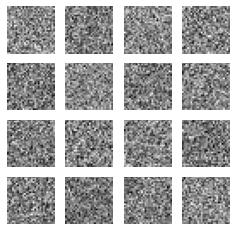

In [6]:
noise = tf.random.normal(shape = [16,random_noise_dimension])
test_image = generator(noise)
show_multiple_images(test_image,n_cols = 4)

In [7]:
discriminator = Sequential([
                            Flatten(input_shape = [28,28]),
                            Dense(128,activation = 'selu'),
                            Dense(64,activation = 'selu'),
                            Dense(1,activation = 'sigmoid')
])

In [8]:
gan = Sequential([generator,discriminator])


In [9]:
discriminator.compile(loss = 'binary_crossentropy',optimizer='adam')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy',optimizer='rmsprop')

In [10]:
def train_gan(epochs,random_noise_dimension,dataset):
    generator,discriminator = gan.layers

    for epoch in range(epochs):
        print("Epoch : {}/{}".format(epoch+1,epochs))
        for real_images in dataset:
            batch_size  = real_images.shape[0]

            noise = tf.random.normal(shape = [batch_size,random_noise_dimension])
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images,real_images],axis = 0)
            discriminator_labels = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)

            discriminator.trainable = True

            discriminator.train_on_batch(mixed_images,discriminator_labels)

            noise = tf.random.normal(shape = [batch_size,random_noise_dimension])

            generator_labels = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise,generator_labels)
        show_multiple_images(fake_images,8)
        plt.show()



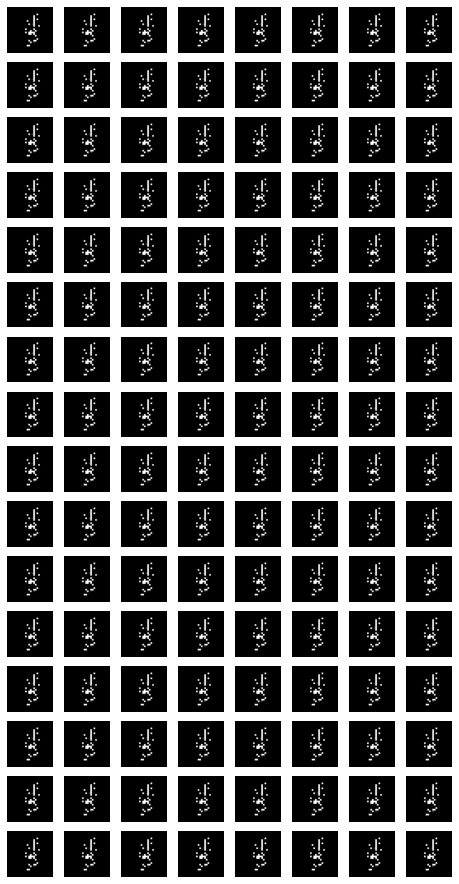

In [12]:
train_gan(40,random_noise_dimension,train_dataset)